# Dependencies and files

## Imports

In [ ]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import decoupler as dc
from scipy.interpolate import UnivariateSpline
from statsmodels.stats.multitest import multipletests

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

## Global variables

In [2]:
figures_dir = f'tf_activity/figures/'
os.makedirs(figures_dir, exist_ok=True)

In [31]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [70]:
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

## Load files

### ChEA3 database

Let's load TF's for brain from [ChEA3 database](https://maayanlab.cloud/chea3/)

In [6]:
with open('data/tf_activity/brain.TFs.gmt', 'r') as chea_dataset:
    chea_dict = dict(map(lambda x: x.split('\t\t'), chea_dataset.readlines()))
    chea_dict = {key:value.split('\t') for key, value in chea_dict.items()}

len(chea_dict)

1620

### ANCOVA results

In [3]:
res_dict = dict()

res_dict['human-chimp'] = pd.read_csv('data/tf_activity/activation_comp_human_chimp.csv', index_col=0)
res_dict['human-macaque'] = pd.read_csv('data/tf_activity/activation_comp_human_macaque.csv', index_col=0)
res_dict['chimp-macaque'] = pd.read_csv('data/tf_activity/activation_comp_chimp_macaque.csv', index_col=0)

res_dict['human-chimp'].head()

,p_value,F
AHR,0.459942,0.877035
AIRE,0.008250,4.414109
AP1,0.143064,1.898604
APEX1,0.235019,1.470270
AR,0.341854,1.142743


### Pseudobulks

In [59]:
adata_pb = sc.read_h5ad("data/pseudobulks/pseudobulk_all_mammals.h5ad")
adata_pb

AnnData object with n_obs × n_vars = 89 × 9209
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'X_pca_mean_norm', 'condition_colors', 'layer_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_mean_norm'
    varm: 'PCs', 'X_pca_mean_norm'
    layers: 'counts', 'mean_norm', 'psbulk_props'

### Activity data

In [13]:
acts = sc.read_h5ad('data/tf_activity/activity.h5ad')
acts

AnnData object with n_obs × n_vars = 89 × 549
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size', 'layer_c'
    uns: 'X_pca_mean_norm', 'condition_colors', 'layer_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_mean_norm', 'padj_ulm', 'score_ulm'

### Collectri Database

In [23]:
collectri = dc.op.collectri(organism='human')
collectri.head()

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation


### Human-specific genes

In [36]:
n_clusters = 6
filepath = f'data/human_specific_genes/human_clusters_edgeR_{n_clusters}.csv'
labels = pd.read_csv(filepath, index_col=0)['0']
hs_genes = labels.index.tolist()
len(hs_genes)

26

# TF activity

## Human-specific TFs

Let's define human-specific TF's

In [14]:
# let's leave only TF active in brain
brain_tf = res_dict['human-chimp'].index.intersection(chea_dict.keys())
brain_tf

Index(['AHR', 'AIRE', 'AR', 'ARNT', 'ARX', 'ASCL1', 'ASCL2', 'ATF1', 'ATF2',
       'ATF3',
       ...
       'ZNF331', 'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF436',
       'ZNF699', 'ZNF76', 'ZNF91'],
      dtype='object', length=463)

In [8]:
# Apply multiple testing correction

for key in res_dict.keys():
    res_dict[key] = res_dict[key].loc[brain_tf].copy()
    mult_test = multipletests(res_dict[key]['p_value'], method='fdr_bh')
    res_dict[key]['p_val_adj'] = mult_test[1]

res_dict['human-chimp'].head()

,p_value,F,p_val_adj
AHR,0.459942,0.877035,0.556013
AIRE,0.008250,4.414109,0.043408
AR,0.341854,1.142743,0.458778
ARNT,0.379948,1.049028,0.483286
ARX,0.006823,4.588881,0.037758


In [9]:
sign_tf = lambda df: df[df.p_val_adj < 0.05].index
sign_tf_dict = {key:sign_tf(df) for key, df in res_dict.items()}
sign_tf_dict

{'human-chimp': Index(['AIRE', 'ARX', 'ATF3', 'ATF5', 'ATF6', 'BARX2', 'BHLHE40', 'CDX1',
        'CEBPA', 'CREB3L1',
        ...
        'ZBTB7A', 'ZFP42', 'ZFPM1', 'ZIC1', 'ZKSCAN7', 'ZNF362', 'ZNF382',
        'ZNF384', 'ZNF699', 'ZNF91'],
       dtype='object', length=101),
 'human-macaque': Index(['AHR', 'ARNT', 'ARX', 'ASCL1', 'ASCL2', 'ATF2', 'ATF3', 'ATF5', 'ATF6',
        'BACH1',
        ...
        'ZNF236', 'ZNF263', 'ZNF331', 'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF384',
        'ZNF436', 'ZNF699', 'ZNF91'],
       dtype='object', length=290),
 'chimp-macaque': Index(['AHR', 'AIRE', 'AR', 'ATF5', 'BACH1', 'BATF', 'BCL11A', 'BCL11B',
        'BCL6', 'BHLHA15',
        ...
        'ZNF263', 'ZNF350', 'ZNF354C', 'ZNF362', 'ZNF382', 'ZNF384', 'ZNF436',
        'ZNF699', 'ZNF76', 'ZNF91'],
       dtype='object', length=278)}

Let's use the same definition as with genes $(HC\bigcap HM)\setminus CM$

In [10]:
hs_tf = sign_tf_dict['human-chimp'].intersection(sign_tf_dict['human-macaque']).difference(sign_tf_dict['chimp-macaque'])
hs_tf, hs_tf.size

(Index(['ARX', 'ATF3', 'ATF6', 'BARX2', 'CRX', 'DLX4', 'EN1', 'ESRRG', 'FOXA2',
        'GATA3', 'GTF3A', 'HSF1', 'IRF2', 'KLF10', 'MBD1', 'MYOG', 'NFIX',
        'NR4A3', 'OVOL1', 'PAX2', 'PLAG1', 'PLAGL1', 'POU2F1', 'POU5F1', 'RXRA',
        'SP4', 'TBX2', 'TGIF1', 'THRA', 'ZKSCAN7'],
       dtype='object'),
 30)

## Visualization

In [15]:
scaled_adata_list = list()

for sample in acts.obs['sample_id'].unique():
    scaled_adata_list.append(sc.pp.scale(acts[acts.obs['sample_id'] == sample], copy=True))

scaled_acts = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_acts

AnnData object with n_obs × n_vars = 89 × 549
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size', 'layer_c'
    uns: 'X_pca_mean_norm', 'pca'
    obsm: 'X_pca', 'X_pca_mean_norm', 'padj_ulm', 'score_ulm'

In [16]:
act_df = pd.DataFrame(scaled_acts.X, index=scaled_acts.obs_names, columns=scaled_acts.var_names)

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = act_df.loc[act_df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
act_df = act_df.loc[sample_order['all']]
act_df_hs = act_df[hs_tf].copy()

## Hierarchial

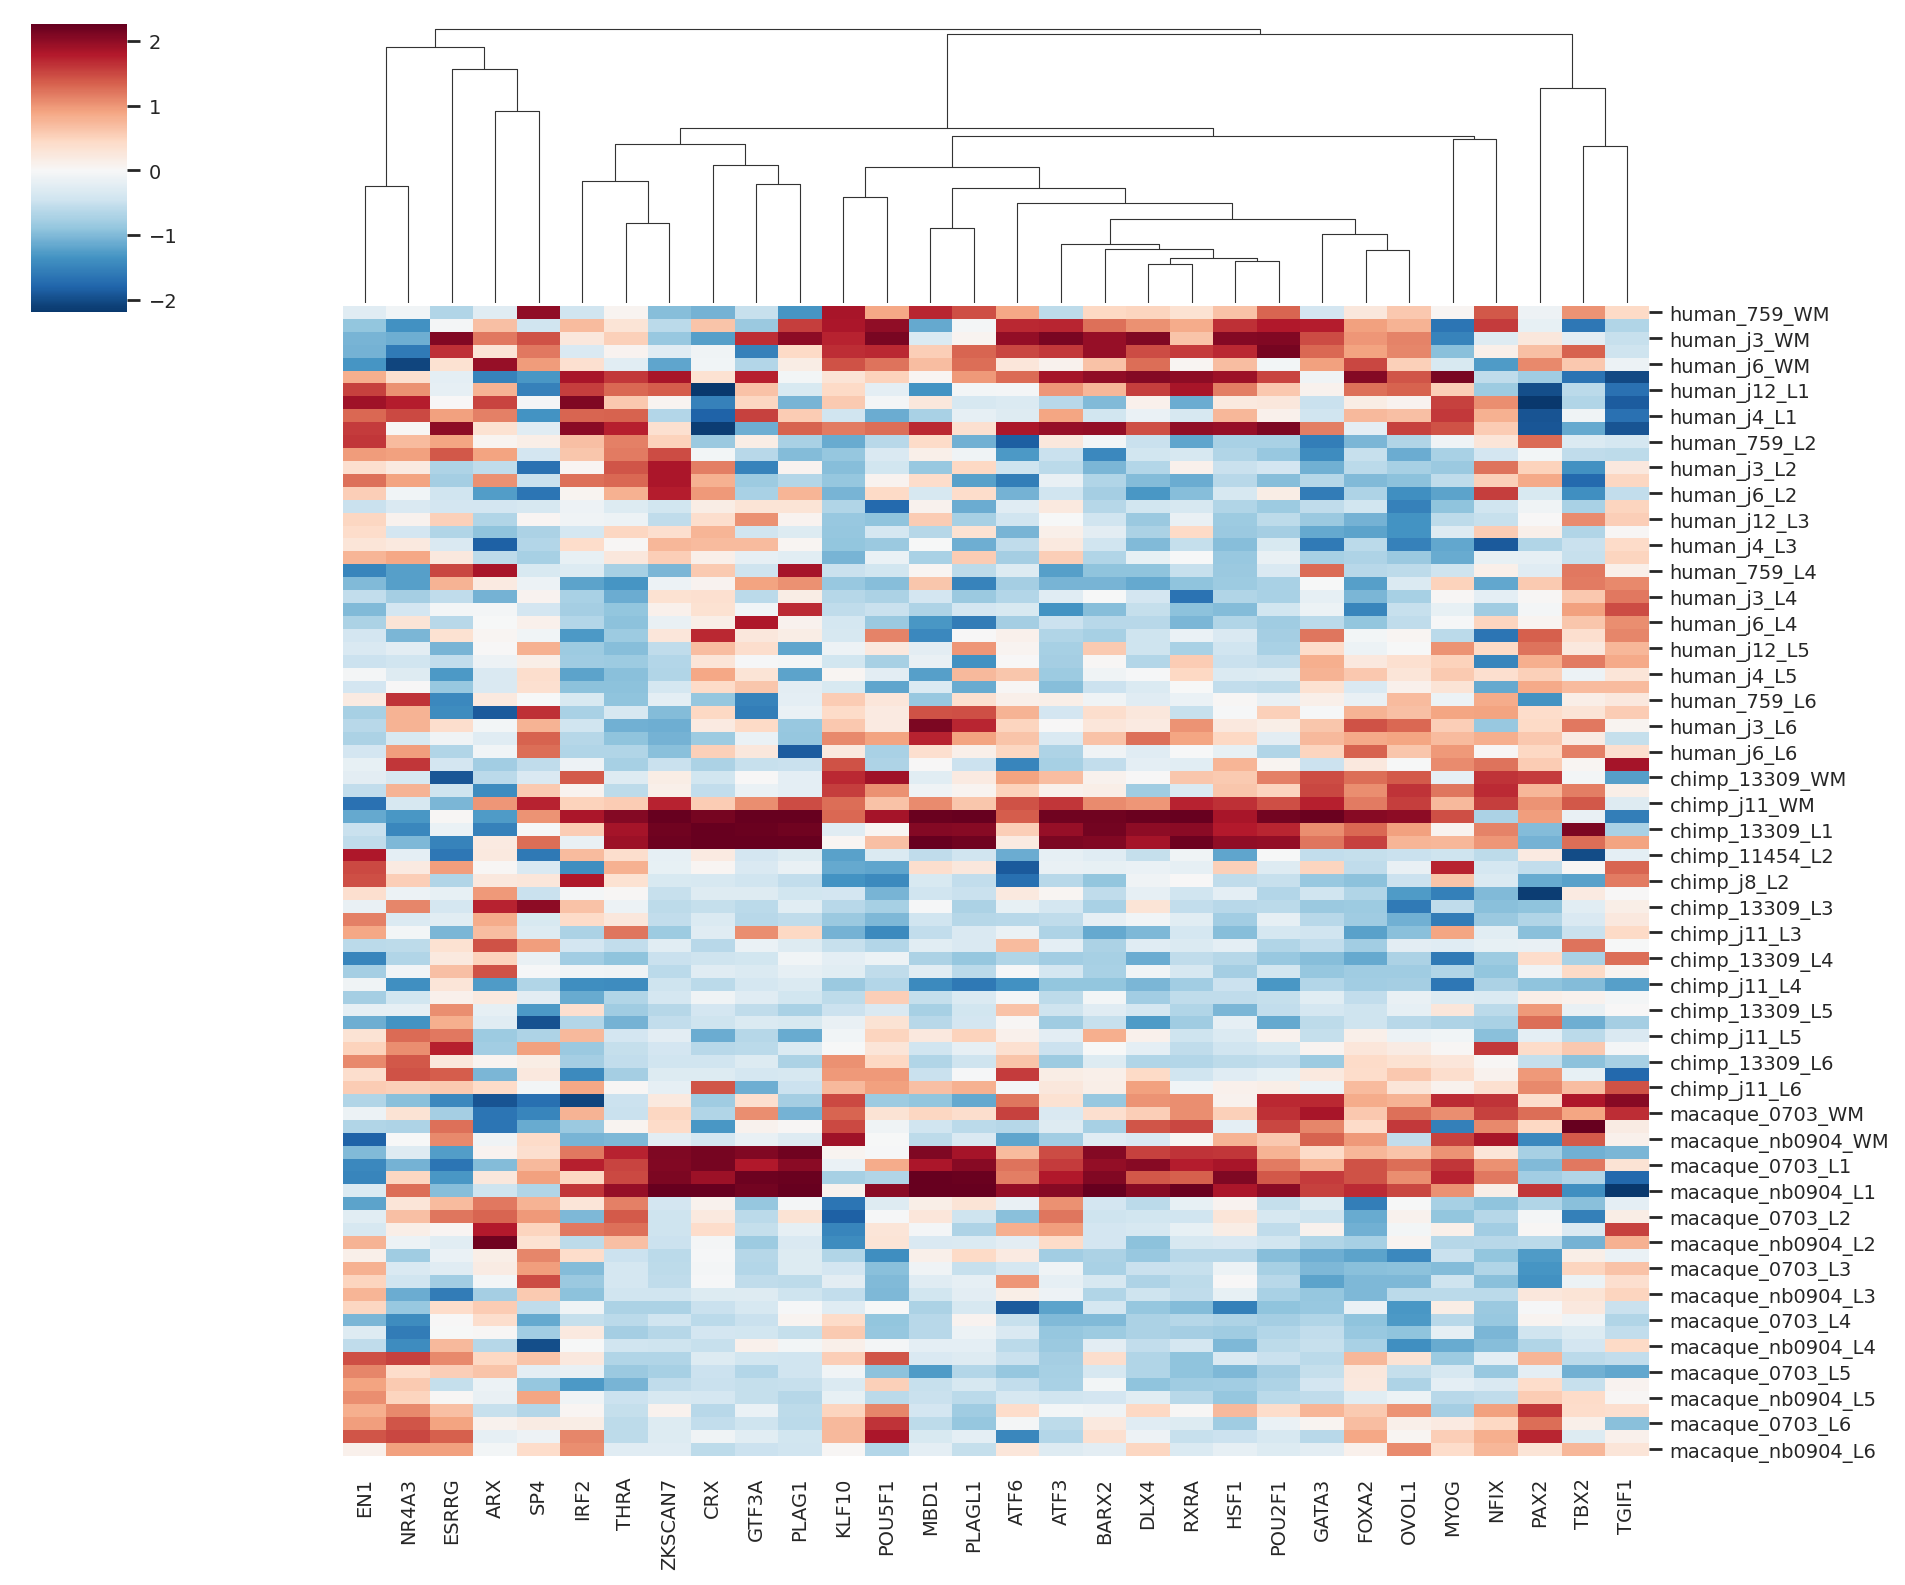

In [18]:
sns.set(font_scale=0.8)
cluster_grid = sns.clustermap(act_df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

<Axes: >

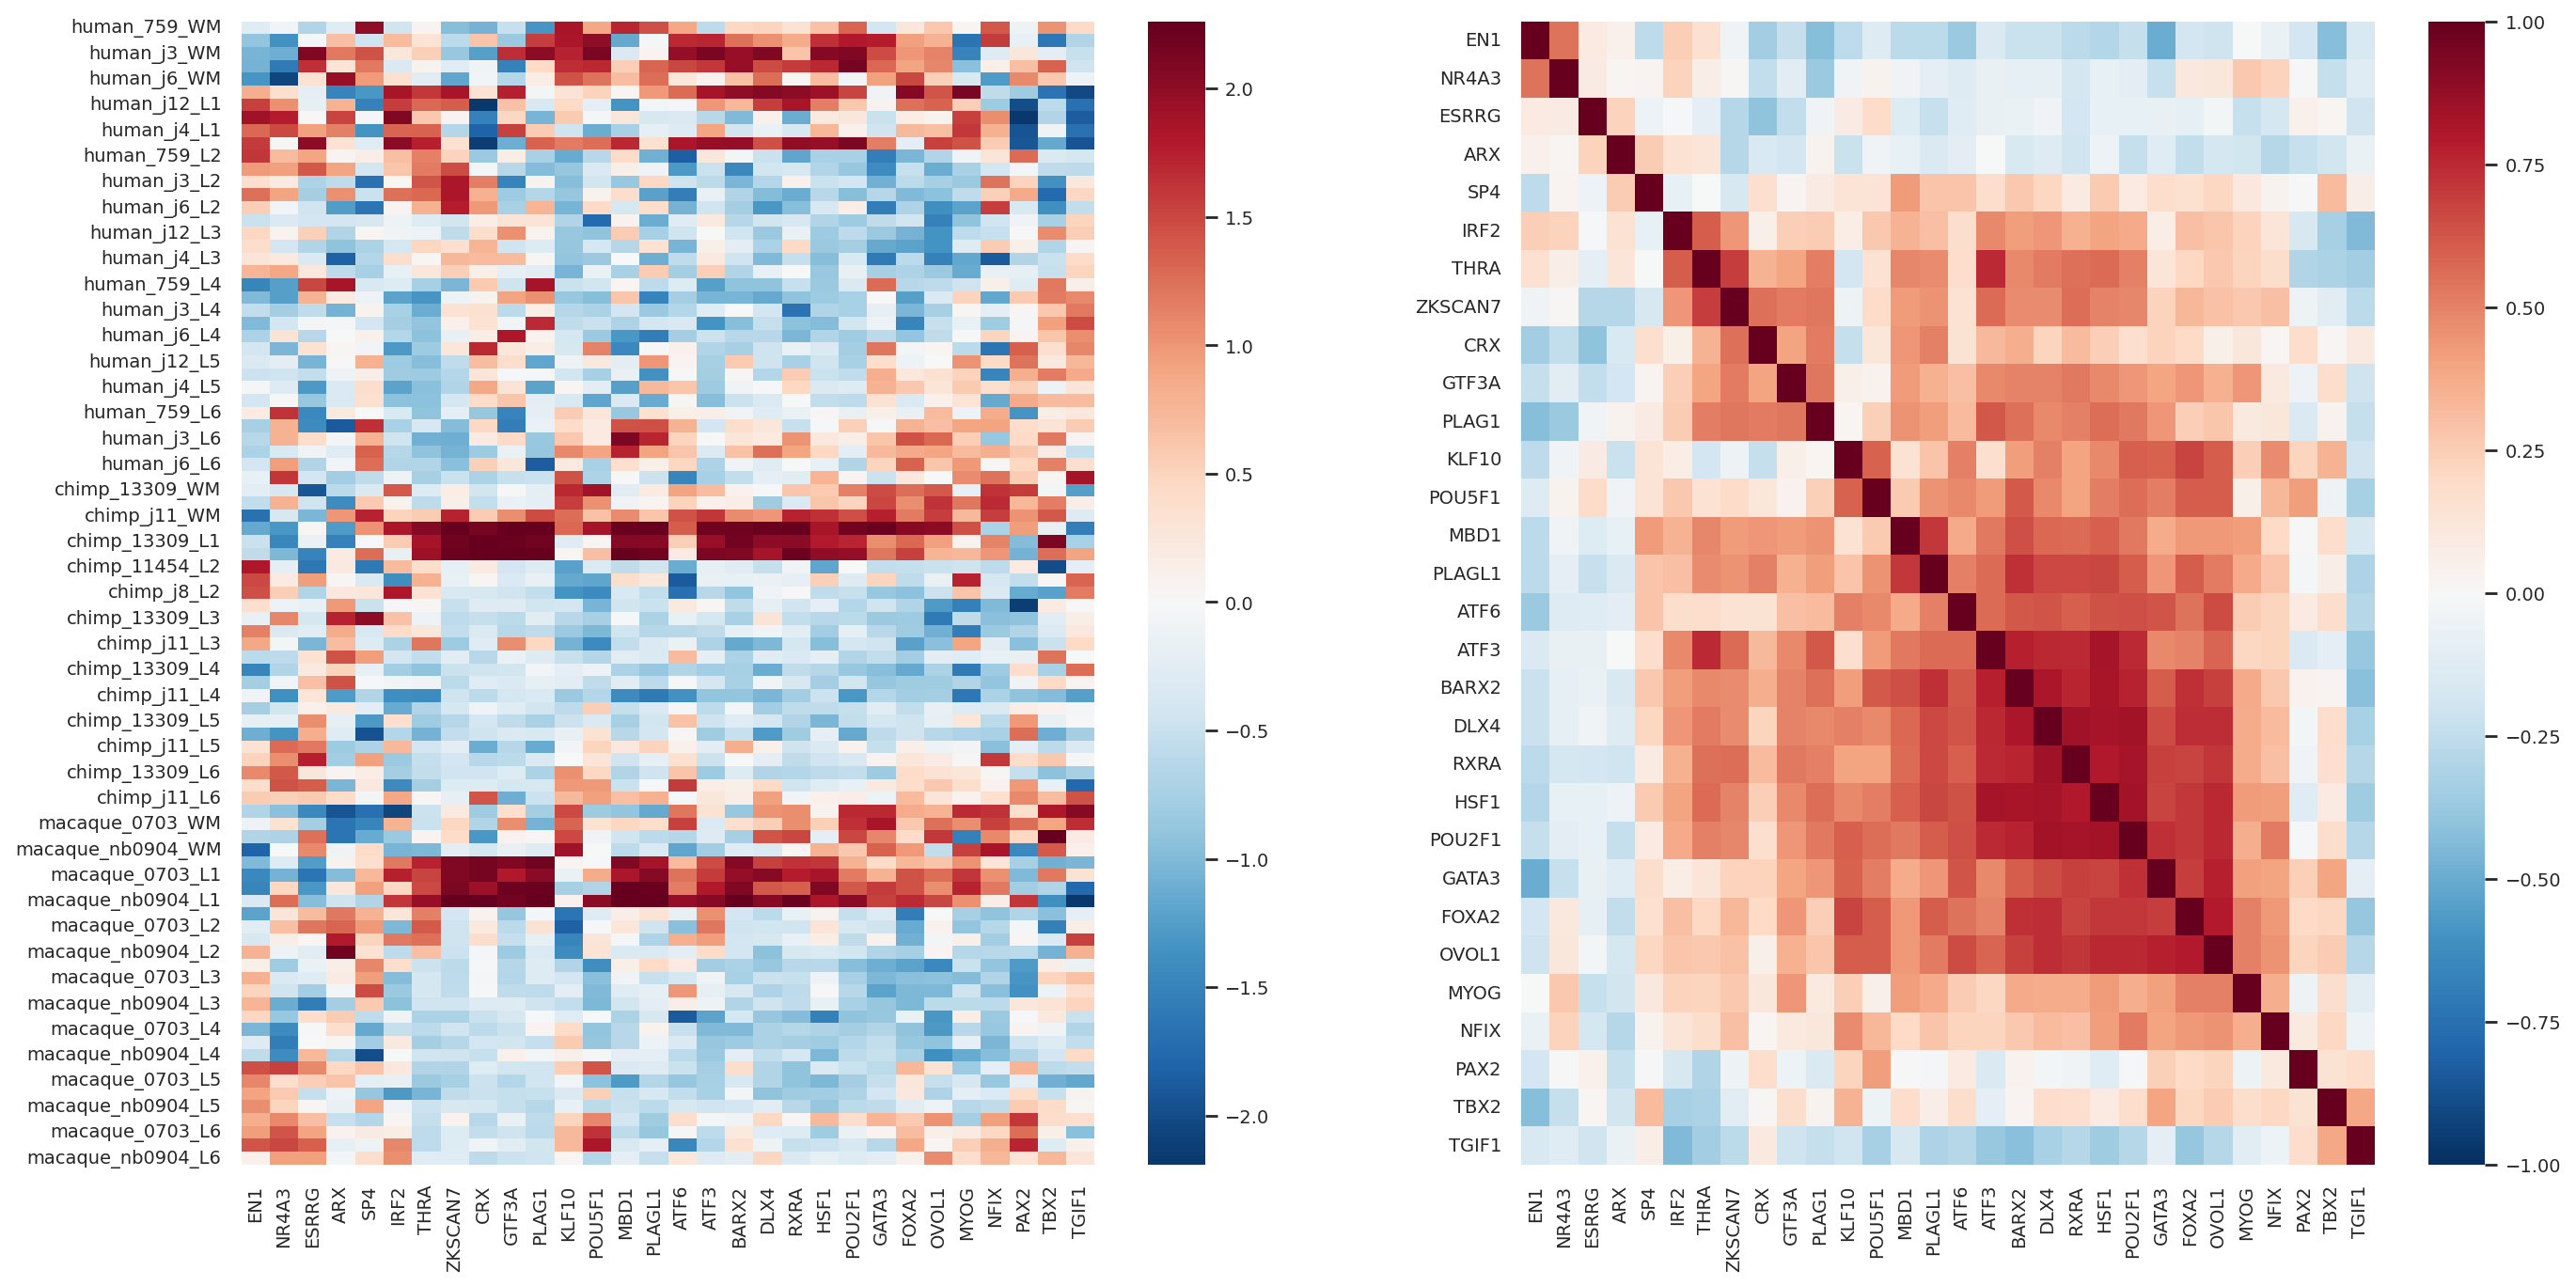

In [19]:
from sklearn.metrics.pairwise import pairwise_kernels
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

gene_order = act_df_hs.columns[cluster_grid.dendrogram_col.reordered_ind]
sns.heatmap(act_df_hs[gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[0])

aff_matrix = pairwise_kernels(act_df_hs.T, metric='cosine')
aff_df = pd.DataFrame(aff_matrix, index=act_df_hs.columns, columns=act_df_hs.columns)
sns.heatmap(aff_df.loc[gene_order, gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[1], vmin=-1, vmax=1)

## Human-specific TFs that regulate human-specific genes

In [37]:
collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))]

,source,target,weight,resources,references,sign_decision
24315,HSF1,RGS2,1.0,ExTRI,23587726,default activation


Let's visualise human-specific TFs that regulate human-specific genes

In [75]:
act_df_layer = act_df.copy()
act_df_layer['layer'] = acts.obs.loc[act_df.index, 'layer']
act_df_layer['condition'] = acts.obs.loc[act_df.index, 'condition']
act_df_layer.head()

layer_mean_acts = act_df_layer.groupby(['condition', 'layer']).mean()
layer_mean_acts.head()

AHR      AIRE       AP1     APEX1        AR    ARID4A  \
condition layer                                                               
chimp     L1     1.979210  0.119077  2.011950  1.825910  1.431198 -0.732182   
          L2     0.075255  1.354879  0.013734 -0.312993 -0.618766  1.103920   
          L3     0.115504 -0.058936 -0.431798 -0.847010 -0.370546  0.306791   
          L4    -0.356891 -0.649090 -0.795887  0.055980 -0.439108 -0.326774   
          L5    -0.708758 -0.731613 -0.677969 -0.639367 -0.703838 -0.074683   

                   ARID4B      ARNT       ARX     ASCL1  ...    ZNF331  \
condition layer                                          ...             
chimp     L1    -2.240179  2.104342 -0.869430  1.115963  ...  0.419180   
          L2     0.230312 -0.186110  0.157304  0.450509  ... -0.393083   
          L3     0.374577 -0.099798  1.063574 -0.074196  ...  0.086690   
          L4    -0.053896 -0.222030  0.521737  0.255723  ... -0.158801   
          L5     0.664371 -0.470632 -0.266330  0.028334  ...  0.245212   

                   ZNF350   ZNF354C    ZNF362    ZNF382    ZNF384    ZNF436  \
condition layer                                                               
chimp     L1    -1.077782  1.504799  1.275201 -1.806449  1.468732  0.631793   
          L2     0.241631 -0.628302 -0.091342 -0.826905 -0.689942  0.194089   
          L3     0.446173  0.196076 -0.535593  0.137401 -0.954034  0.362031   
          L4     1.161674 -0.190067 -0.741509  0.118809 -0.828890 -0.684321   
          L5    -0.527869 -1.062095 -0.521960  0.762872 -0.305351 -0.197274   

                   ZNF699     ZNF76     ZNF91  
condition layer                                
chimp     L1     1.622497 -0.987253  2.034540  
          L2    -0.165923 -0.413524 -0.936737  
          L3    -0.603755 -0.063484 -0.181827  
          L4    -0.631258  0.296778 -0.453233  
          L5    -0.515739  0.297889  0.168156  

[5 rows x 549 columns]

In [76]:
df = pd.DataFrame(adata_pb.X, index=adata_pb.obs_names, columns=adata_pb.var_names)

sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))].target.unique()].copy()

df_layer = df.copy()
df_layer['layer'] = adata_pb.obs.loc[df.index, 'layer']
df_layer['condition'] = adata_pb.obs.loc[df.index, 'condition']
df_layer.head()

layer_mean = df_layer.groupby(['condition', 'layer']).mean()
layer_mean.head()

DUSP18   ANGPTL4    NUP133       FRY     FKBP7    SNAP29  \
condition layer                                                               
chimp     L1     0.049531  0.094301  0.536894  1.066358  0.138307  0.376770   
          L2     0.033174  0.030989  0.536963  1.258506  0.062400  0.396204   
          L3     0.090028  0.032303  0.467871  1.149863  0.039483  0.421577   
          L4     0.071439  0.018671  0.520329  1.163919  0.050927  0.455307   
          L5     0.063878  0.050544  0.514393  1.111029  0.046191  0.405272   

                     ECI2     LRRC4   DNAJC19     RAB7A  ...    ORMDL3  \
condition layer                                          ...             
chimp     L1     0.411641  0.009351  0.551242  1.427884  ...  0.625505   
          L2     0.292380  0.005501  0.627544  1.454306  ...  0.620510   
          L3     0.214693  0.009488  0.618200  1.497331  ...  0.623526   
          L4     0.220533  0.008643  0.620462  1.461603  ...  0.592237   
          L5     0.247097  0.006362  0.679349  1.479595  ...  0.559226   

                    ABCD2    SNRPD3    HIF1AN   MAPKAP1    DNAJB4     HMGCR  \
condition layer                                                               
chimp     L1     0.376513  0.866939  0.000000  0.407497  0.475679  1.535610   
          L2     0.370928  0.744214  0.000000  0.393670  0.480048  1.644443   
          L3     0.361015  0.747555  0.001763  0.470562  0.425088  1.602153   
          L4     0.347853  0.729632  0.002723  0.462762  0.416066  1.566591   
          L5     0.271147  0.725655  0.001042  0.431329  0.382784  1.555033   

                  CAMSAP1     TFCP2     ROCK1  
condition layer                                
chimp     L1     0.867329  0.864368  0.305316  
          L2     0.988771  0.890391  0.117697  
          L3     1.048514  0.821652  0.098082  
          L4     1.035194  0.781335  0.100793  
          L5     0.991290  0.813666  0.083887  

[5 rows x 9209 columns]

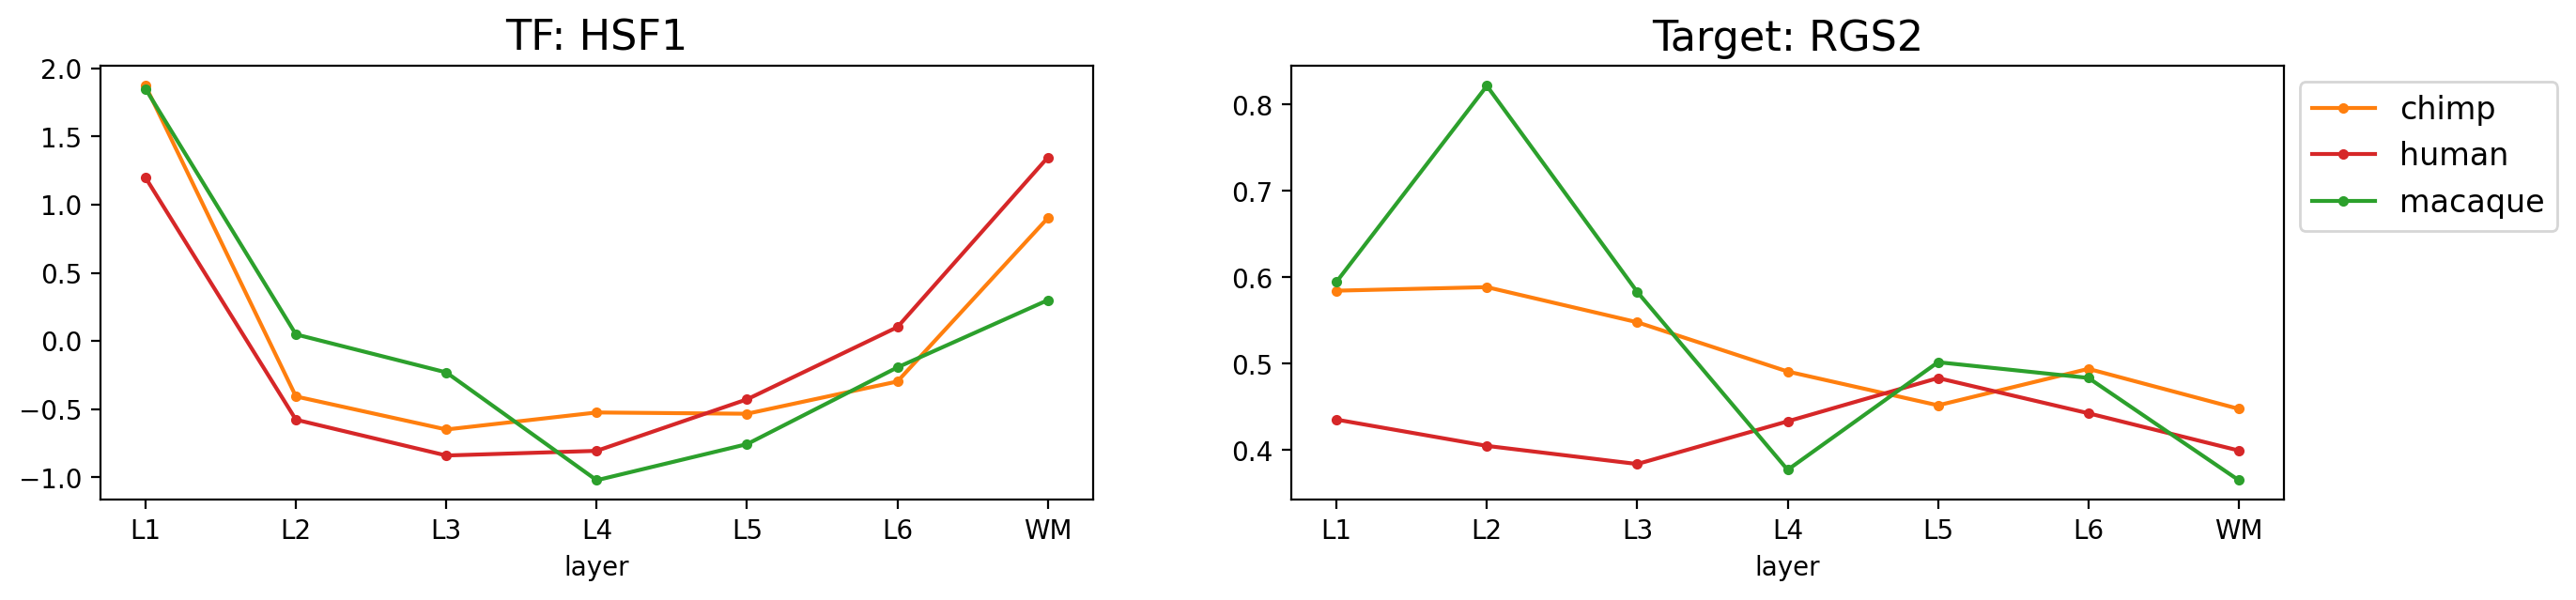

In [89]:
mpl.rcdefaults()
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15, 3))

tf = "HSF1"

(
    layer_mean_acts[tf]
    .reorder_levels(['layer', 'condition'])
    .unstack().loc[layers]
    .plot
    .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax1, marker='.')
)

ax1.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
ax1.get_legend().remove()
ax1.set_title(f"TF: {tf.upper()}", fontsize=16)
ax1.grid(False)

gene = "RGS2"

(
    layer_mean[gene]
    .reorder_levels(['layer', 'condition'])
    .unstack().loc[layers]
    .plot
    .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax2, marker='.')
)

ax2.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
ax2.set_title(f"Target: {gene.upper()}", fontsize=16)
ax2.grid(False)

In [ ]:
grid = np.linspace(1, 7, 400)
genes = ["HSF1"]
df_cont = act_df_layer.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

array = np.zeros((grid.size, len(genes)))
df_list = []

for specie in conditions:
    for i, gene in enumerate(genes):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline_acts = pd.concat(df_list)

In [87]:
df_cont = df_layer.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)
genes = ["RGS2"]
array = np.zeros((grid.size, len(genes)))
df_list = []

for specie in conditions:
    for i, gene in enumerate(genes):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

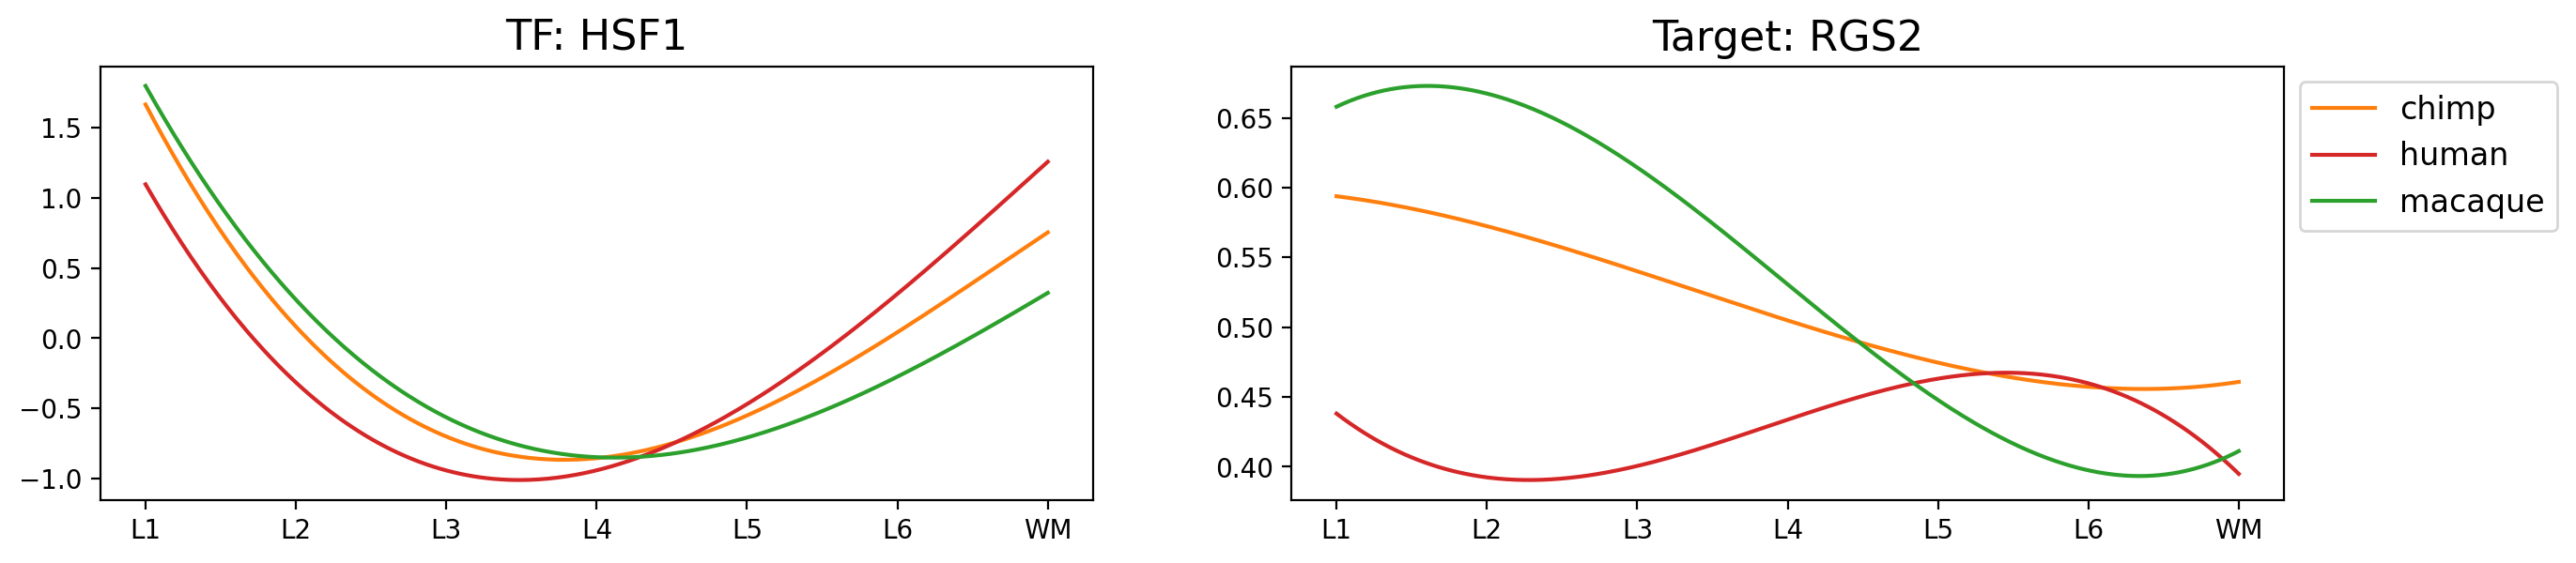

In [90]:
mpl.rcdefaults()
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15, 3))

tf = "HSF1"
df_cluster_spline = df_spline_acts[[tf, 'condition']]
df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=tf)
df_cluster_spline.index = grid
df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax1)

ax1.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
ax1.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
ax1.set_title(f"TF: {tf.upper()}", fontsize=16)
ax1.get_legend().remove()
ax1.grid(False)


gene = "RGS2"
df_cluster_spline = df_spline[[gene, 'condition']]
df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=gene)
df_cluster_spline.index = grid
df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax2)

ax2.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
ax2.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
ax2.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
ax2.set_title(f"Target: {gene.upper()}", fontsize=16)
ax2.grid(False)

In [91]:
gene_df = df[df_spline.columns[:-1]].copy()
act_df = act_df[collectri[(collectri.source.isin(hs_tf.to_list())) & (collectri.target.isin(hs_genes))].source.unique().tolist()].copy()

corr_df = pd.concat([gene_df, act_df], axis=1)
corr_df = corr_df.corr(method='spearman').loc[act_df.columns, gene_df.columns]
corr_df

,RGS2
HSF1,0.183401
